<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRISS Wide Field Slitless Spectroscopy (WFSS) Pipeline Notebook

**Authors**: R. Plesha<br>
**Last Updated**: July 24, 2025<br>
**Pipeline Version**: 1.19.1 (Build 12.0)

# **Purpose**:

This notebook provides a framework for processing generic Near-Infrared Imager and Slitless Spectrograph (NIRISS) wide field slitless spectroscopy (WFSS) data through the James Webb Space Telescope (JWST) pipeline.  Data is assumed to be located in one observation folder according to paths set up below. It should not be necessary to edit any cells other than in the [Configuration](#1.-Configuration) section unless modifying the standard pipeline processing options.

**Data**:
This example uses data from the [Program ID 2079](https://www.stsci.edu/jwst/science-execution/program-information?program=2079) observation 004 (PI: Finkelstein) observing the Hubble Ultra Deep Field (HUDF). The observations are in three [NIRISS filters](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-pupil-and-filter-wheels): F115W, F150W, and F200W use both GR150R and GR150C [grisms](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-gr150-grisms). In this example we are only looking at data using the F200W filter. A [NIRISS WFSS observation sequence](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-observing-strategies/niriss-wfss-recommended-strategies) typically consists of a direct image followed by a grism observation in the same blocking filter to help identify the sources in the field. In program 2079, the exposure sequence follows the pattern: direct image -> GR150R -> direct image -> GR150C -> direct image.

Example input data to use will be downloaded automatically unless disabled (i.e., to use local files instead).

**JWST pipeline version and CRDS context** This notebook was written for the calibration pipeline version given above. The JWST Calibration Reference Data System (CRDS) context used is associated with the pipeline version as listed [here](https://jwst-crds.stsci.edu/display_build_contexts/). If you use different pipeline version or CRDS context, please read the relevant release notes ([here for pipeline](https://github.com/spacetelescope/jwst), [here for CRDS](https://jwst-crds.stsci.edu/)) for possibly relevant changes.<BR>

**Updates**:
This notebook is regularly updated as improvements are made to the pipeline. Find the most up to date version of this notebook at: https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
July 24, 2025: original notebook released<br>

<hr style="border:1px solid gray"> </hr>

## Table of Contents
1. [Configuration](#1.-Configuration) 
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup (ignore if not using demo data)](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
3. [Detector 1 Pipeline](#5.-Detector1-Pipeline)
4. [Image2 Pipeline](#6.-Image2-Pipeline)
5. [Image3 Pipeline](#7.-Image3-Pipeline)
6. [Visualize the data](#8.-Visualize-the-drizzle-combined-image)

<hr style="border:1px solid gray"> </hr>

## 1. Configuration
------------------
Set basic configuration for running notebook.

#### Install dependencies and parameters

To make sure that the pipeline version is compatabile with the steps
discussed below and the required dependencies and packages are installed,
you can create a fresh conda environment and install the provided
`requirements.txt` file:
```
conda create -n niriss_wfss_pipeline python=3.11
conda activate niriss_wfss_pipeline
pip install -r requirements.txt
```

Set the basic parameters to use with this notebook. These will affect
what data is used, where data is located (if already in disk), and
pipeline modules run in this data. The list of parameters are:

* demo_mode
* directories with data
* pipeline modules

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Adjust any parameters in the cell directly below this before running to ensure <code>demo_mode</code> runs correctly.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this mode this notebook will download example data from the Barbara A.
Mikulski Archive for Space Telescopes (MAST) and process everything through the pipeline. This will all happen in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.

Set <code>demo_mode = False</code> if you want to process your own data that has already been downloaded and provide the location of the data in the `sci_dir` variable in the cell below.<br>

In [2]:
# Set parameters for demo_mode, channel, band, data mode directories, and 
# processing steps.

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    user_home_dir = os.path.expanduser('~')

    # Point to where science observation data are
    # Assumes uncalibrated data in sci_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    sci_dir = os.path.join(user_home_dir, 'nis_wfss_demo_data/2079/obs004/')

    print(f'Running using user input data from: {sci_dir}')

cwd = os.getcwd()
# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
doimage2 = True  # calwebb_image2
doimage3 = True  # calwebb_image3
dospec2 = True # calwebb_spec2
dospec3 = True # calwebb_spec3
doviz = True # Visualize outputs

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need
to configure our environment. This includes defining a CRDS cache
directory in which to keep the reference files that will be used by the
calibration pipeline.

If the root directory for the local CRDS cache directory has not been set
already, it will be set to create one in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------

# Set CRDS context (if overriding to use a specific version of reference
# files; leave commented out to use latest reference files by default)
#%env CRDS_CONTEXT  jwst_1413.pmap

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path in use
print(f"CRDS local filepath: {os.environ['CRDS_PATH']}")
print(f"CRDS file server: {os.environ['CRDS_SERVER_URL']}")

CRDS local filepath: /home/rplesha/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2. Package Imports
------------------

In [4]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time
import json

# Data calculations and manipulation
import numpy as np
import pandas as pd

# -----------------------Plotting Imports----------------------------------
from matplotlib import pyplot as plt
from matplotlib import patches
# interactive plots within the notebook
%matplotlib inline 

# -----------------------Astronomy Imports--------------------------------
# ASCII files, and downloading demo files
from astroquery.mast import MastMissions

# Astropy routines for visualizing detected sources:
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import constants as const

# for JWST calibration pipeline
import jwst
import crds

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from jwst import datamodels
from jwst.associations import asn_gather

# Echo pipeline version and CRDS context in use
print(f"JWST Calibration Pipeline Version: {jwst.__version__}")
print(f"Using CRDS Context: {crds.get_context_name('jwst')}")

CRDS - INFO -  Calibration SW Found: jwst 1.19.0 (/user/rplesha/astroconda_setup/envs/jwst-1.19.0-wfss/lib/python3.12/site-packages/jwst-1.19.0.dist-info)


JWST Calibration Pipeline Version: 1.19.0
Using CRDS Context: jwst_1410.pmap


### Define convenience functions

In [5]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [6]:
def check_steps_run(filename):
    
    # Read in file as datamodel
    dm = datamodels.open(filename)
    
    # Check which steps were run
    print(f"{dm.meta.filename} - {dm.meta.exposure.type}")
    for step, status in dm.meta.cal_step.instance.items():
        print(f"{step}: {status}")
    print()

In [7]:
def check_ref_file_used(filename):

    # Read in file as datamodel
    dm = datamodels.open(filename)

    # Check which reference files were used
    print(f"{dm.meta.filename} - {dm.meta.exposure.type}")
    for step, status in dm.meta.ref_file.instance.items():
        print(f"{step}: {status}")
    print()

<hr style="border:1px solid gray"> </hr>

## 3. Demo Mode Setup (skip to [4. Directory Setup](#4.-Directory-Setup) if not using demo data)
------------------
If running in demonstration mode, set up the program information to retrieve the uncalibrated data automatically from MAST using [astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html). Here we will be using the [MastMissions](https://spacetelescope.github.io/mast_notebooks/notebooks/multi_mission/missions_mast_search/missions_mast_search.html) interface which allows for flexibility in search criteria, and is equivalent to using the [JWST mission specific search](https://mast.stsci.edu/search/ui/#/jwst) on MAST. <br>

For illustrative purposes, we focus on data taken through the NIRISS [F200W filter](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-filters) and start with uncalibrated data products. To search for additional filters, update the `niriss_pupil` field in `query_criteria` to be a comma separated list of filters in a single string value, i.e. "F200W, F115W". To search for a specific grism used, add the `opticalElements` field in `query_criteria`, setting the value equal to "GR150R" or "GR150C". Note that searching based on a specific grism will not download the associated direct images.

Information about the JWST file naming conventions can be found at: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [8]:
# Set up the program information and paths for demo program
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST')
    program = 2079
    sci_observtn = '004'
    
    # creating a directory for the data called "nis_wfss_demo_data" 
    #   located in the directory you are currently in
    data_dir = os.path.join(cwd, 'nis_wfss_demo_data')
    sci_dir = os.path.join(data_dir, f"{program}/obs{sci_observtn}")

    # Create the directories if they do not exist
    os.makedirs(sci_dir, exist_ok=True)

Running in demonstration mode and will download example data from MAST


<div class="alert alert-block alert-warning">
This demo selects only filter <b>F200W</b> data by default; this observation contains data for the F115W and F150W filters, too
</div>

In [9]:
if demo_mode:
    print(f'Using the Missions MAST interface to find data for Program {program} observation {sci_observtn}:')
    missions = MastMissions(mission='jwst')

    # query the data; sometimes this step can take a bit of time
    datasets = missions.query_criteria(instrume='NIRISS',  # From Near-Infrared Imager and Slitless Spectrograph
                                       #opticalElements='GR150R', # uncomment to filter on only GR150R grism data (no direct images)
                                       niriss_pupil='F200W',  # Download only the F200W filter data for this example
                                       program=program,  # Proposal number 2079
                                       observtn=sci_observtn, # observation 004
                                      )
    products = missions.get_unique_product_list(datasets)
    print(f'Total number of unique products found: {len(products)}')

    # filter down to only the files that we need from MAST
    files_to_download = missions.filter_products(products, file_suffix=['_uncal'])
    asns_to_download = missions.filter_products(products, file_suffix=['_asn']) # '_pool' to download the pool.csv file instead
    
    print(f'Total number of uncal files to download: {len(files_to_download)}')
    print(f'Total number of associations to download: {len(asns_to_download)}')

Using the Missions MAST interface to find data for Program 2079 observation 004:
INFO: 3639 of 5855 products were duplicates. Only returning 2216 unique product(s). [astroquery.mast.utils]
INFO: To return all products, use `MastMissions.get_product_list` [astroquery.mast.missions]
Total number of unique products found: 2216
Total number of uncal files to download: 14
Total number of associations to download: 23


Download all the uncal files and place them into the appropriate
directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file
may be incomplete, and cause crashes later on!
</div>

In [10]:
if demo_mode:
    print('Downloading the data:')
    # download uncal file
    manifest = missions.download_products(files_to_download, flat=True, download_dir=sci_dir)
    
    # download the association files to the top level science directory to move around in the directory setup
    asns_manifest = missions.download_products(asns_to_download, flat=True, download_dir=sci_dir)

There is currently a bug in the downloading through the MAST missions interface where all filters are downloaded for level 3 products, so we temporarily remove the F115W and F150W image3 and spec3 association files that were downloaded so that we do not see crashes when running the image3 pipeline and spec3 pipeline.

In [30]:
for spec3_asn in glob.glob(os.path.join(sci_dir, '*spec3*_asn.json')) + glob.glob(os.path.join(sci_dir, '*image3*_asn.json')):
    temp_asn = json.load(open(spec3_asn))
    # check the associations to see which have the F200W filter in the output product name
    #   we look at what is in a spec3 association file later in the notebook
    if 'f200w' not in temp_asn['products'][0]['name']:
        os.remove(spec3_asn)

<hr style="border:1px solid gray"> </hr>

## 4. Directory Setup
---------------------
Set up detailed paths to input/output stages here. 

<i>Note: for this demo, we are creating custom associations that will point to the appropriate path locations. The default associations downloaded from MAST will expect the outputs of all stages to be in a common directory.</i>

<hr style="border:1px solid gray"> </hr>

## 5. Detector1 Pipeline
Run the datasets through the [Detector1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) stage of the pipelineto apply detector level calibrations and create a countrate data product where slopes are fitted to the integration ramps. These `*_rate.fits` products are 2D (nrows x ncols), averaged over all integrations. 3D countrate data products (`*_rateints.fits`) are also created (nintegrations x nrows x ncols) which have the fitted ramp slopes for each integration.

In [12]:
time_det1_start = time.perf_counter()

In [13]:
uncal_files = sorted(glob.glob(os.path.join(sci_dir, '*_uncal.fits')))

# Run Detector1 stage of pipeline, specifying:
# output directory to save *_rateints.fits files
# save_results flag set to True so the *rateints.fits files are saved
if dodet1:
    for uncal in uncal_files:
        rate_result = Detector1Pipeline.call(uncal,
                                             output_dir=sci_dir,
                                             save_results=True)
else:
    print('Skipping Detector1 processing')

2025-08-11 10:56:39,454 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.
2025-08-11 10:56:39,462 - stpipe - INFO - PARS-CHARGEMIGRATIONSTEP parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-chargemigrationstep_0016.asdf
2025-08-11 10:56:39,482 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-jumpstep_0085.asdf
2025-08-11 10:56:39,497 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-detector1pipeline_0001.asdf
2025-08-11 10:56:39,518 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-08-11 10:56:39,519 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-08-11 10:56:39,520 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-08-11 10:56:39,521 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep ins

### Inspect Level 1 Output Products
Shown below are the `*_rate.fits` file outputs of the Detector1Pipeline. If no modifications to the steps at this stage, you can also save time by downloading these `*_rate.fits` files directly from MAST and starting at stage2. In stage1, both the direct images (EXP_TYPE=NIS_IMAGE) and dispersed grism images (EXP_TYPE=NIS_WFSS) were calibrated.

Let's look at the observation sequence these rate files follow to get a better idea of a typical NIRISS WFSS exposure sequence. We will sort the files by exposure time to aid in this. 

In addition to the `EXP_TYPE` keyword, the keyword `FILTER` can be used to distinguish which type of exposure you are looking at. `FILTER=CLEAR` indicates a direct image while `FILTER=GR150R` or `FILTER=GR150C` indicates a dispersed image. The keyword `PUPIL` is the blocking filter used. The sequence follows the pattern: direct image -> grism -> direct image -> grism. There are also multiple dither positions for the dispersed images and the direct images. The multiple direct image dithers will be combined in image3, while the multiple dithers in the dispersed images are combined as individual sources after extraction in spec3. 

In [14]:
# first look for all of the rate files you have downloaded
rate_files = sorted(glob.glob(os.path.join(sci_dir, "*rate.fits")))

for file_num, ratefile in enumerate(rate_files):

    rate_hdr = fits.getheader(ratefile) # Primary header for each rate file

    # information we want to store that might be useful to us later for evaluating the data
    temp_hdr_dict = {"PATHNAME": ratefile,
                     "FILENAME": rate_hdr['FILENAME'],
                     "FILTER": [rate_hdr["FILTER"]], # Grism; GR150R/GR150C
                     "PUPIL": [rate_hdr["PUPIL"]], # Filter used; F090W, F115W, F140M, F150W F158M, F200W
                     "EXPSTART": [rate_hdr['EXPSTART']], # Exposure start time (MJD)
                     "PATT_NUM": [rate_hdr["PATT_NUM"]], # Position number within dither pattern for WFSS
                     "NUMDTHPT": [rate_hdr["NUMDTHPT"]], # Total number of points in entire dither pattern
                     "XOFFSET": [rate_hdr["XOFFSET"]], # X offset from pattern starting position for NIRISS (arcsec)
                     "YOFFSET": [rate_hdr["YOFFSET"]], # Y offset from pattern starting position for NIRISS (arcsec)
                     }

    # Turn the dictionary into a pandas dataframe
    if file_num == 0:
        # if this is the first file, make an initial dataframe
        rate_df = pd.DataFrame(temp_hdr_dict)
    else:
        # otherwise, append to the dataframe for each file
        new_data_df = pd.DataFrame(temp_hdr_dict)

        # merge the two dataframes together to create a dataframe with all 
        rate_df = pd.concat([rate_df, new_data_df], ignore_index=True, axis=0)

rate_dfsort = rate_df.sort_values('EXPSTART', ignore_index=False)

# Look at the resulting dataframe
rate_dfsort[['FILENAME', 'FILTER', 'PUPIL', 'EXPSTART', 'PATT_NUM', 'NUMDTHPT', 'XOFFSET', 'YOFFSET']]

FILENAME  FILTER  PUPIL      EXPSTART  \
0   jw02079004003_02101_00001_nis_rate.fits   CLEAR  F200W  59976.655916   
1   jw02079004003_03101_00001_nis_rate.fits  GR150R  F200W  59976.660812   
2   jw02079004003_03101_00002_nis_rate.fits  GR150R  F200W  59976.722187   
3   jw02079004003_03101_00003_nis_rate.fits  GR150R  F200W  59976.783568   
4   jw02079004003_04101_00001_nis_rate.fits   CLEAR  F200W  59976.846204   
5   jw02079004003_04101_00002_nis_rate.fits   CLEAR  F200W  59976.849679   
6   jw02079004003_04101_00003_nis_rate.fits   CLEAR  F200W  59976.853152   
7   jw02079004003_04101_00004_nis_rate.fits   CLEAR  F200W  59976.856611   
8   jw02079004003_05101_00001_nis_rate.fits  GR150C  F200W  59976.861511   
9   jw02079004003_05101_00002_nis_rate.fits  GR150C  F200W  59976.922897   
10  jw02079004003_05101_00003_nis_rate.fits  GR150C  F200W  59976.984350   
11  jw02079004003_06101_00001_nis_rate.fits   CLEAR  F200W  59977.047145   
12  jw02079004003_06101_00002_nis_rate.fits   CLEAR  F200W  59977.050614   
13  jw02079004003_06101_00003_nis_rate.fits   CLEAR  F200W  59977.054075   

    PATT_NUM  NUMDTHPT    XOFFSET  YOFFSET  
0          1         4   0.000099   9.9490  
1          1         4   0.000099   9.9490  
2          2         4   0.567803  11.1062  
3          3         4  -0.567604   8.7918  
4          1         4  -0.567604   8.7918  
5          2         4   0.184401   8.5907  
6          3         4  -0.109901   9.0203  
7          4         4   9.907557  -0.0464  
8          1         4   9.907557  -0.0464  
9          2         4  10.475260   1.1108  
10         3         4   9.339854  -1.2036  
11         1         3   9.339854  -1.2036  
12         2         3  10.091858  -1.4047  
13         3         3   9.797556  -0.9751

Shown below are the rate files to give an idea of the above sequence visually. Grid lines are shown as a visual guide for the dithers

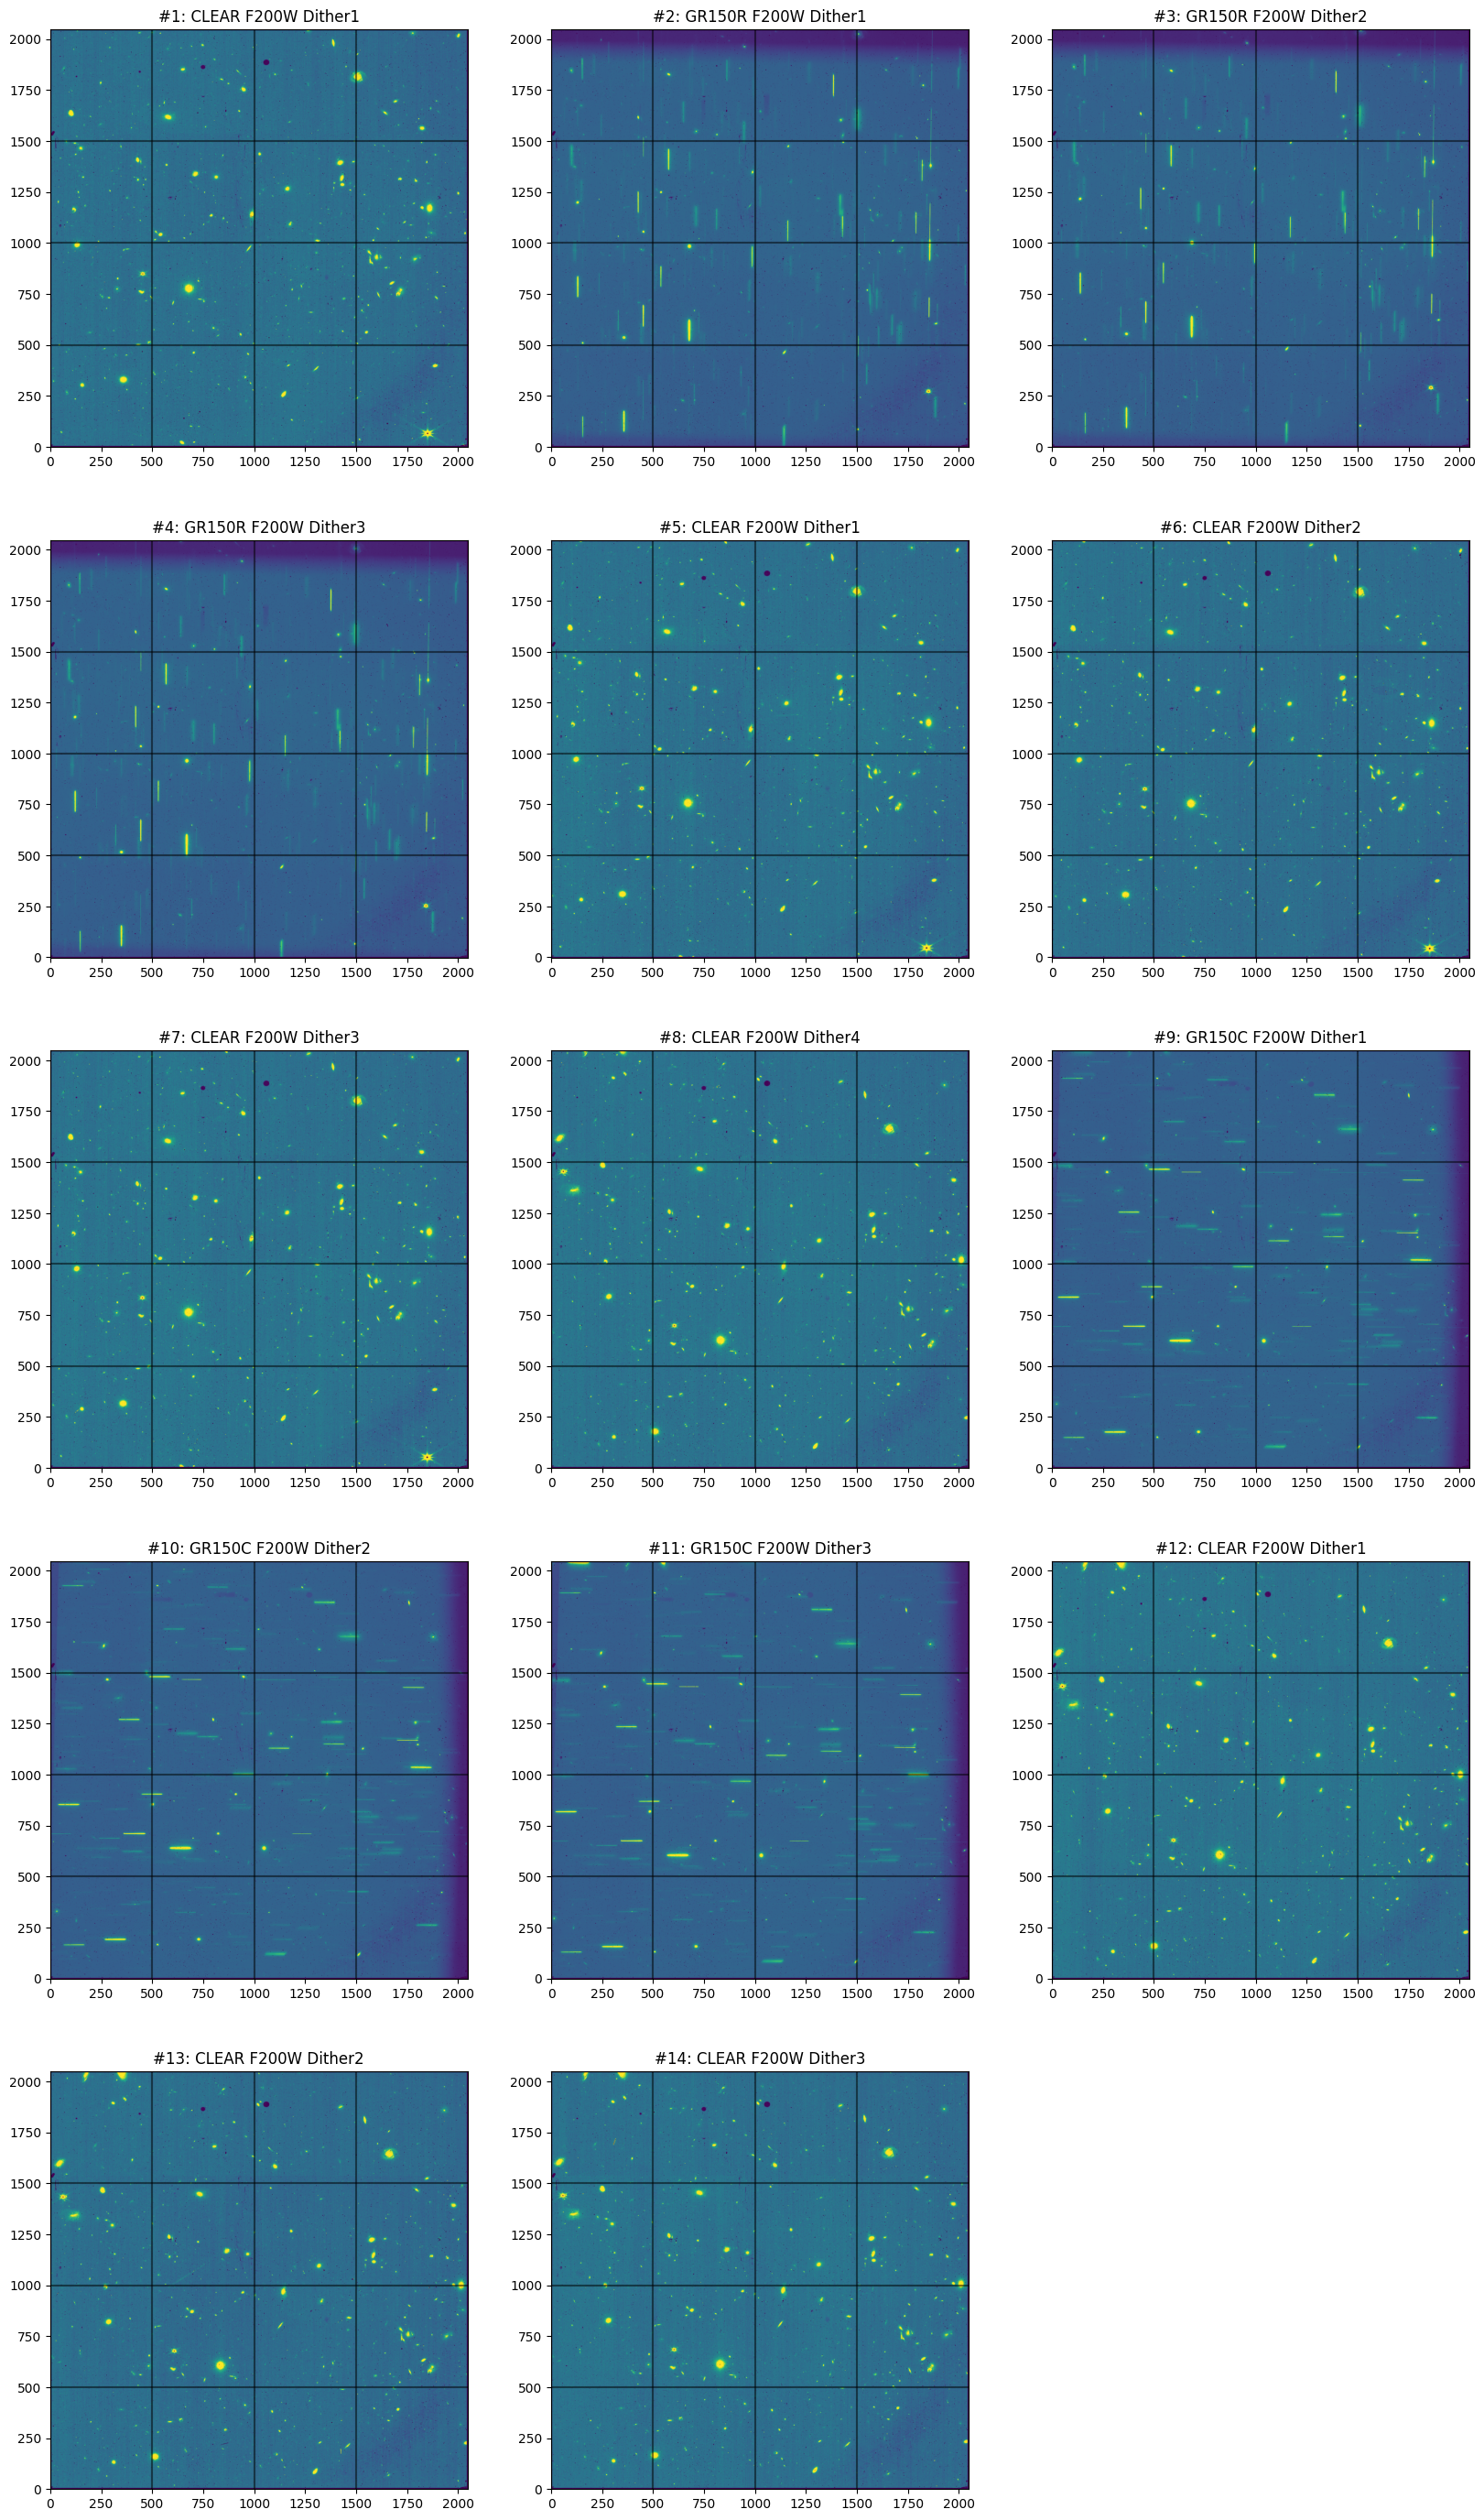

In [15]:
if doviz:
    
    # plot set up
    fig = plt.figure(figsize=(20, 35))
    cols = 3
    rows = int(np.ceil(14 / cols))
    
    # loop over the first 14 rate files and plot them
    for plt_num, rf in enumerate(rate_dfsort['PATHNAME']):
    
        # determine where the subplot should be
        xpos = (plt_num % 40) % cols
        ypos = ((plt_num % 40) // cols) # // to make it an int.
    
        # make the subplot
        ax = plt.subplot2grid((rows, cols), (ypos, xpos))
    
        # open the data and plot it
        with fits.open(rf) as hdu:
            data = hdu[1].data
            data[np.isnan(data)] = 0 # filling in nan data with 0s to help with the matplotlib color scale.
            
            ax.imshow(data, vmin=0, vmax=1.5, origin='lower')
    
            # adding in grid lines as a visual aid
            for gridline in [500, 1000, 1500]:
                ax.axhline(gridline, color='black', alpha=0.5)
                ax.axvline(gridline, color='black', alpha=0.5)
    
            ax.set_title(f"#{plt_num+1}: {hdu[0].header['FILTER']} {hdu[0].header['PUPIL']} Dither{hdu[0].header['PATT_NUM']}")

Additionally, you can look into what steps were performed and reference files used during the Detector1 stage of the pipeline

In [16]:
dir_img_rate = rate_dfsort[rate_dfsort['FILTER'] == 'CLEAR']['PATHNAME'].iloc[0]
grism_img_rate = rate_dfsort[rate_dfsort['FILTER'] == 'GR150C']['PATHNAME'].iloc[0]

check_steps_run(dir_img_rate)
check_steps_run(grism_img_rate)

jw02079004003_02101_00001_nis_rate.fits - NIS_IMAGE
charge_migration: COMPLETE
clean_flicker_noise: SKIPPED
dark_sub: COMPLETE
dq_init: COMPLETE
gain_scale: SKIPPED
group_scale: SKIPPED
ipc: SKIPPED
jump: COMPLETE
linearity: COMPLETE
persistence: COMPLETE
ramp_fit: COMPLETE
refpix: COMPLETE
saturation: COMPLETE
superbias: COMPLETE

jw02079004003_05101_00001_nis_rate.fits - NIS_WFSS
charge_migration: COMPLETE
clean_flicker_noise: SKIPPED
dark_sub: COMPLETE
dq_init: COMPLETE
gain_scale: SKIPPED
group_scale: SKIPPED
ipc: SKIPPED
jump: COMPLETE
linearity: COMPLETE
persistence: COMPLETE
ramp_fit: COMPLETE
refpix: COMPLETE
saturation: COMPLETE
superbias: COMPLETE



You can also check which reference files were used to calibrate the dataset:

In [17]:
check_ref_file_used(dir_img_rate)
check_ref_file_used(grism_img_rate)

jw02079004003_02101_00001_nis_rate.fits - NIS_IMAGE
crds: {'context_used': 'jwst_1410.pmap', 'sw_version': '12.1.11'}
dark: {'name': 'crds://jwst_niriss_dark_0228.fits'}
gain: {'name': 'crds://jwst_niriss_gain_0006.fits'}
linearity: {'name': 'crds://jwst_niriss_linearity_0017.fits'}
mask: {'name': 'crds://jwst_niriss_mask_0035.fits'}
persat: {'name': 'crds://jwst_niriss_persat_0004.fits'}
readnoise: {'name': 'crds://jwst_niriss_readnoise_0005.fits'}
saturation: {'name': 'crds://jwst_niriss_saturation_0015.fits'}
superbias: {'name': 'crds://jwst_niriss_superbias_0238.fits'}
trapdensity: {'name': 'crds://jwst_niriss_trapdensity_0002.fits'}
trappars: {'name': 'crds://jwst_niriss_trappars_0002.fits'}

jw02079004003_05101_00001_nis_rate.fits - NIS_WFSS
crds: {'context_used': 'jwst_1410.pmap', 'sw_version': '12.1.11'}
dark: {'name': 'crds://jwst_niriss_dark_0228.fits'}
gain: {'name': 'crds://jwst_niriss_gain_0006.fits'}
linearity: {'name': 'crds://jwst_niriss_linearity_0017.fits'}
mask: {'na

In [18]:
# Print out the time benchmark
time_det1_end = time.perf_counter()
print(f"Runtime for Detector1: {(time_det1_end - time_det1_start)/60:0.0f} minutes")

Runtime for Detector1: 31 minutes


<hr style="border:1px solid gray"> </hr>

## 6. Image2 Pipeline

Our next step will focus only on calibrating only the direct images now in order to obtain a source catalog and segmentation mapping of the field to use as input into the Spec2Pipeline stage later. 

In the [Image2 stage of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html), calibrated unrectified data products are created (`*_cal.fits` files). 

In this pipeline processing stage, the [world coordinate system (WCS)](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step) is assigned, the data are [flat fielded](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step), and a [photometric calibration](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step) is applied to convert from units of countrate (ADU/s) to surface brightness (MJy/sr).

By default, the [background subtraction step](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step)
and the [resampling step](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step) are turned off for NIRISS at this stage of the pipeline. The background subtraction is turned off since there is no background template for the imaging mode and the local background is removed during the background correction for photometric measurements around individual sources. The resampling step occurs during the `Image3` stage by default. While the resampling step can be turned on during the `Image2` stage to, e.g., generate a source catalog for each image, the data quality from the `Image3` stage will be better since the bad pixels, which adversely affect
both the centroids and photometry in individual images, will be mostly removed.

In [19]:
time_image2 = time.perf_counter()

### Image2 Association Files

First, we will take a look inside the association files to better understand everything that is contained in them. For image2 association files, there should be one asn file for each dither position in an observing sequence which is set by the [exposure strategy](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-observing-strategies/niriss-wfss-recommended-strategies). In this case, that should match the number of direct images (`FILTER=CLEAR`) in `rate_df` because each direct image is at a unique dither position (XOFFSET, YOFFSET) within an observing sequence. For this program and observation, there is one direct image with only one dither before the grism images, another direct image with four dithers between the change in grisms, and a direct image with three dithers at the end of a blocking filter sequence. This leads to a total of eight images per observing sequence, with five observing sequences in the observation using the blocking filters F115W -> F115W -> F150W -> F150W -> F200W. In demo mode, we have only downloaded the final observing sequence with F200W.

In [20]:
if doimage2:
    
    image2_asns = glob.glob(os.path.join(sci_dir, "*image2*_asn.json"))

    # Verify the number of associations
    print(len(image2_asns), 'Image2 ASN files') # there should be 8 asn files for image2 in demo mode
    # the number of association files should match the number of direct image rate files
    print(len(rate_df[rate_df['FILTER'] == 'CLEAR']), 'Direct Image rate files')

8 Image2 ASN files
8 Direct Image rate files


In [23]:
if doimage2:
    # look at one of the association files
    image2_asn_data = json.load(open(image2_asns[0]))
    for key, data in image2_asn_data.items():
        print(f"{key} : {data}")

asn_type : image2
asn_rule : candidate_Asn_Lv2Image
version_id : 20250603t205244
code_version : 1.18.0
degraded_status : No known degraded exposures in association.
program : 02079
constraints : DMSAttrConstraint({'name': 'program', 'sources': ['program'], 'value': '2079'})
DMSAttrConstraint({'name': 'is_tso', 'sources': ['tsovisit'], 'value': None})
DMSAttrConstraint({'name': 'instrument', 'sources': ['instrume'], 'value': 'niriss'})
DMSAttrConstraint({'name': 'detector', 'sources': ['detector'], 'value': 'nis'})
DMSAttrConstraint({'name': 'opt_elem', 'sources': ['filter'], 'value': 'clear'})
DMSAttrConstraint({'name': 'opt_elem2', 'sources': ['pupil'], 'value': 'f200w'})
DMSAttrConstraint({'name': 'fxd_slit', 'sources': ['fxd_slit'], 'value': None})
DMSAttrConstraint({'name': 'subarray', 'sources': ['subarray'], 'value': 'full'})
DMSAttrConstraint({'name': 'channel', 'sources': ['channel'], 'value': None})
DMSAttrConstraint({'name': 'slit', 'sources': ['fxd_slit'], 'value': None})
Co

From this association, we can tell many things about the observation:
1. From `asn_type` and `asn_rule`, we can see that this is an image2 association
2. From `code_version` we can see what version of the code this association was created with. If this does not match the version of the pipeline you are currently using, you are encouraged to create new associations directly from the [pool file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/asn_generate.html) or by providing [a list of exposures](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/asn_from_list.html) and their associated exposure type to ensure there are no errors downstream in the pipeline.
3. From `degraded_status` we can see that there are no exposures to not be included in the calibration.
4. From `constraints`, we can see this is not a time series observation (TSO), the observation is part of program 2079, observed with NIRISS with the CLEAR (i.e. imaging for WFSS) and F200W blocking filter.
5. From `products` we can see there is only one exposure associated. This is typical for image2 where there is usually only one exposure per dither per observing sequence.

In [24]:
if doimage2:
    print(f'asn_type : {image2_asn_data["asn_type"]}')
    print(f'code_version : {image2_asn_data["code_version"]}')
    
    # in particular, take a closer look at the product filenames with the association file:
    for product in image2_asn_data['products']:
        for key, value in product.items():
            if key == 'members':
                print(f"{key}:")
                for member in value:
                    print(f"    {member['expname']} {member['exptype']}")
            else:
                print(f"{key}: {value}")

asn_type : image2
code_version : 1.18.0
name: jw02079004003_04101_00003_nis
members:
    jw02079004003_04101_00003_nis_rate.fits science


### Run image2

The `*_rate.fits` products will be calibrated into `*_cal.fits` files. More information about the steps performed in the Image2 part of the pipeline can be found in the [Image2 pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html).

In [25]:
if doimage2:
    os.chdir(sci_dir)
    
    for img2_asn in image2_asns:
        # calibrate with the image2 pipeline
        img2 = Image2Pipeline.call(img2_asn, save_results=True)

    os.chdir(cwd)

2025-08-11 11:44:03,182 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-resamplestep_0001.asdf
2025-08-11 11:44:03,196 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-image2pipeline_0002.asdf
2025-08-11 11:44:03,211 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2025-08-11 11:44:03,212 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-08-11 11:44:03,213 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-08-11 11:44:03,214 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2025-08-11 11:44:03,215 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2025-08-11 11:44:03,216 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2025-08-11 11:44:03,415 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with arg

We can look at which steps were turned on and which reference files were used on the direct images now at stage2 of the imaging pipeline

In [26]:
img2_filename = dir_img_rate.replace('rate', 'cal')
check_steps_run(img2_filename)
check_ref_file_used(img2_filename)

jw02079004003_02101_00001_nis_cal.fits - NIS_IMAGE
assign_wcs: COMPLETE
charge_migration: COMPLETE
clean_flicker_noise: SKIPPED
dark_sub: COMPLETE
dq_init: COMPLETE
flat_field: COMPLETE
gain_scale: SKIPPED
group_scale: SKIPPED
ipc: SKIPPED
jump: COMPLETE
linearity: COMPLETE
persistence: COMPLETE
photom: COMPLETE
ramp_fit: COMPLETE
refpix: COMPLETE
resample: SKIPPED
saturation: COMPLETE
superbias: COMPLETE

jw02079004003_02101_00001_nis_cal.fits - NIS_IMAGE
area: {'name': 'crds://jwst_niriss_area_0017.fits'}
camera: {'name': 'N/A'}
collimator: {'name': 'N/A'}
crds: {'context_used': 'jwst_1410.pmap', 'sw_version': '12.1.11'}
dark: {'name': 'crds://jwst_niriss_dark_0228.fits'}
dflat: {'name': 'N/A'}
disperser: {'name': 'N/A'}
distortion: {'name': 'crds://jwst_niriss_distortion_0037.asdf'}
fflat: {'name': 'N/A'}
filteroffset: {'name': 'crds://jwst_niriss_filteroffset_0006.asdf'}
flat: {'name': 'crds://jwst_niriss_flat_0268.fits'}
fore: {'name': 'N/A'}
fpa: {'name': 'N/A'}
gain: {'name': 'c

<hr style="border:1px solid gray"> </hr>

## 7. Image3 Pipeline

Continuing in calibrating the direct images to obtain a source catalog and segmentation mapping of the field to use as input into the Spec2Pipeline stage later, we move onto the Image3Pipeline step. In the [Image3 stage of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image3.html), the individual `*_cal.fits` files for each of the dither positions are combined to one single distortion corrected image (`*_i2d.fits` files).

By default, the Image3 stage of the pipeline performs the following steps on NIRISS data:
* [tweakreg](https://jwst-pipeline.readthedocs.io/en/latest/jwst/tweakreg/README.html) - creates source catalogs of pointlike sources for each input image. The source catalog for each input image is compared to each other to derive coordinate transforms to align the images relative to each other.
* As of CRDS context jwst_1156.pmap and later, the pars-tweakreg parameter reference file for NIRISS performs an absolute astrometric correction to GAIA data release 3 by default (i.e., the abs_refcat parameter is set to GAIADR3). Though this default correction generally improves results compared with not doing this alignment, it could potentially result in poor performance in crowded or sparse fields, so users are encouraged to check astrometric accuracy and revisit this step if necessary.
* As of pipeline version 1.14.0, the default source finding algorithm for NIRISS is IRAFStarFinder which testing shows returns good accuracy for undersampled NIRISS PSFs at short wavelengths ([Goudfrooij 2022](https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-008324.pdf)).
* [skymatch](https://jwst-pipeline.readthedocs.io/en/latest/jwst/skymatch/description.html) - measures the background level from the sky to use as input into the subsequent outlier detection and resample steps.
* outlier detection - flags any remaining cosmic rays, bad pixels, or other artifacts not already flagged during the detector1 stage of the pipeline, using all input images to create a median image so that outliers in individual images can be identified.
* [resample](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/main.html) - resamples each input image based on its WCS and distortion information and creates a single undistorted image.
* [source catalog](https://jwst-pipeline.readthedocs.io/en/latest/jwst/source_catalog/main.html) - creates a catalog of detected sources along with measured photometries and morphologies (i.e., point-like vs extended). Useful for quicklooks, but optimization is likely needed for specific science cases, which is an on-going investigation for the NIRISS team. Users may wish to experiment with changing the snr_threshold and deblend options. Modifications to the following parameters will not significantly improve data quality and it is advised to keep them at their default values: aperture_ee1, aperture_ee2, aperture_ee3, ci1_star_threshold, ci2_star_threshold.

### Image3 Association Files
The contents of image3 association files are quite similar to image2, but notice now that there are many more members that are associated together, and they use the individual pointing cal files from image2. Image3 resamples and combines images of the same blocking filter (PUPIL for NIRISS WFSS) from all dither and observing sequences to form a single image.

In [55]:
if doimage3:
    image3_asns = glob.glob(os.path.join(sci_dir, "*image3*_asn.json"))
    print(len(image3_asns), 'Image3 ASN files') # there should be 1 image3 association files

    # the number of image3 association files should match the number of unique blocking filters used
    uniq_filters = np.unique(rate_df[rate_df['FILTER'] == 'CLEAR']['PUPIL'])
    print(f"{len(uniq_filters)} unique filter(s) used: {uniq_filters}")

1 Image3 ASN files
1 unique filter(s) used: ['F200W']


In [32]:
if doimage3:
    # open the image3 association to look at
    image3_asn_data = json.load(open(image3_asns[0]))
    print(f'asn_type : {image3_asn_data["asn_type"]}')
    print(f'code_version : {image3_asn_data["code_version"]}')
    
    # in particular, take a closer look at the product filenames with the association file:
    for product in image3_asn_data['products']:
        for key, value in product.items():
            if key == 'members':
                print(f"{key}:")
                for member in value:
                    print(f"    {member['expname']} {member['exptype']}")
            else:
                print(f"{key}: {value}")

asn_type : image3
code_version : 1.18.0
name: jw02079-o004_t001_niriss_clear-f200w
members:
    jw02079004003_02101_00001_nis_cal.fits science
    jw02079004003_04101_00001_nis_cal.fits science
    jw02079004003_04101_00002_nis_cal.fits science
    jw02079004003_04101_00003_nis_cal.fits science
    jw02079004003_04101_00004_nis_cal.fits science
    jw02079004003_06101_00001_nis_cal.fits science
    jw02079004003_06101_00002_nis_cal.fits science
    jw02079004003_06101_00003_nis_cal.fits science


### Run image3

In Image3, the `*_cal.fits` individual pointing files will be calibrated into a single combined `*_i2d.fits` image. More information about the steps performed in the Image3 part of the pipeline can be found in the [Image3 pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image3.html).

In [33]:
if doimage3:    
    os.chdir(sci_dir)
    for img3_asn in image3_asns:
        # calibrate with the image3 pipeline
        img3 = Image3Pipeline.call(img3_asn, save_results=True)
    os.chdir(cwd)

2025-08-11 11:46:00,832 - stpipe - INFO - PARS-TWEAKREGSTEP parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-tweakregstep_0075.asdf
2025-08-11 11:46:00,847 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-outlierdetectionstep_0002.asdf
2025-08-11 11:46:00,863 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-resamplestep_0001.asdf
2025-08-11 11:46:00,873 - stpipe - INFO - PARS-SOURCECATALOGSTEP parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-sourcecatalogstep_0002.asdf
2025-08-11 11:46:00,890 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2025-08-11 11:46:00,890 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-08-11 11:46:00,892 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2025-08-11 11:46:00,893 - stpipe.Image3Pipe

Checking all steps run and reference files used on the direct images

In [34]:
img3_filename = glob.glob(os.path.join(sci_dir, '*i2d.fits'))[0]
check_steps_run(img3_filename)
check_ref_file_used(img3_filename)

jw02079-o004_t001_niriss_clear-f200w_i2d.fits - NIS_IMAGE
assign_wcs: COMPLETE
charge_migration: COMPLETE
clean_flicker_noise: SKIPPED
dark_sub: COMPLETE
dq_init: COMPLETE
flat_field: COMPLETE
gain_scale: SKIPPED
group_scale: SKIPPED
ipc: SKIPPED
jump: COMPLETE
linearity: COMPLETE
outlier_detection: COMPLETE
persistence: COMPLETE
photom: COMPLETE
ramp_fit: COMPLETE
refpix: COMPLETE
resample: COMPLETE
saturation: COMPLETE
skymatch: COMPLETE
superbias: COMPLETE
tweakreg: SKIPPED

jw02079-o004_t001_niriss_clear-f200w_i2d.fits - NIS_IMAGE
area: {'name': 'crds://jwst_niriss_area_0017.fits'}
camera: {'name': 'N/A'}
collimator: {'name': 'N/A'}
crds: {'context_used': 'jwst_1410.pmap', 'sw_version': '12.1.11'}
dark: {'name': 'crds://jwst_niriss_dark_0228.fits'}
dflat: {'name': 'N/A'}
disperser: {'name': 'N/A'}
distortion: {'name': 'crds://jwst_niriss_distortion_0037.asdf'}
fflat: {'name': 'N/A'}
filteroffset: {'name': 'crds://jwst_niriss_filteroffset_0006.asdf'}
flat: {'name': 'crds://jwst_niri

### Inspect Image3 Output Products

Using the `*_i2d.fits` combined image and the source catalog produced by Image3, we can visually inspect if we're happy with where the pipeline found the sources. In the following figures, what has been defined as an extended source by the pipeline is shown in orange-red, and what has been defined as a point source by the pipeline is shown in grey. This definition affects the extraction box in the WFSS images.

In [35]:
# These are all resuts from the Image3 pipeline
image3_i2d = np.sort(glob.glob(os.path.join(sci_dir, '*i2d.fits'))) # combined image over multiple dithers/mosaic
image3_segm = np.sort(glob.glob(os.path.join(sci_dir, '*segm.fits'))) # segmentation map that defines the extent of a source
image3_cat = np.sort(glob.glob(os.path.join(sci_dir, '*cat.ecsv'))) # Source catalog that defines the RA/Dec of a source at a particular pixel

#### i2d & segementation mapping
The segmentation maps are also a product of the Image3 pipeline, and they are used the help determine the source catalog. Let's take a look at those to ensure we are happy with what it is defining as a source.

In the segmentation map, each blue blob should correspond to a physical target. There are cases where sources can be blended, in which case the parameters for making the semgentation map and source catalog should be changed. An example of this can be seen below in the observation 004 F200W filter image where two galaxies at ~(1600, 1300) have been blended into one source. This is discussed in more detail below in [Custom Imaging Pipeline Run](#custom). 

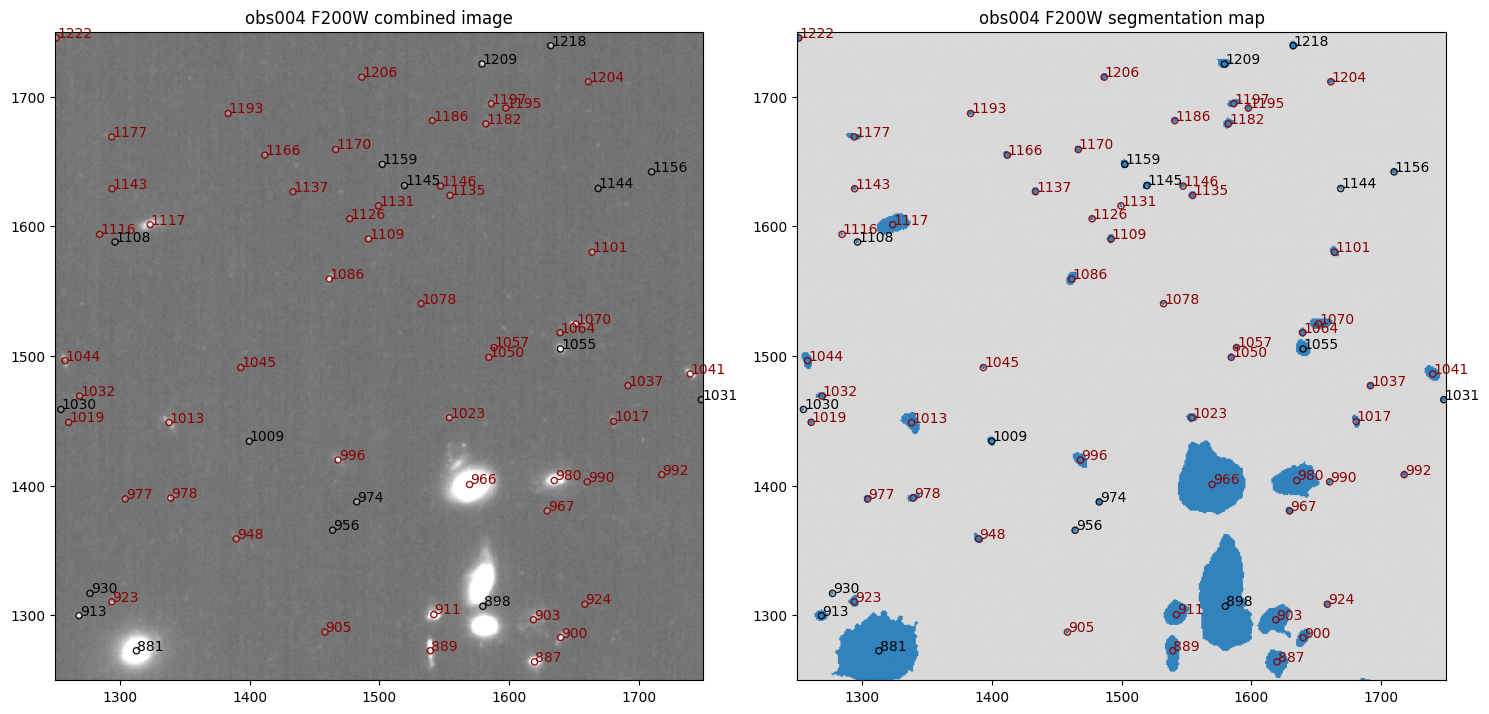

In [36]:
if doimage3 and doviz:            
    cols = 2
    rows = len(image3_i2d)
    
    fig = plt.figure(figsize=(15, 15*(rows/2)))
    
    for plt_num, img in enumerate(np.sort(np.concatenate([image3_segm, image3_i2d]))):
    
        # determine where the subplot should be
        xpos = (plt_num % 40) % cols
        ypos = ((plt_num % 40) // cols) # // to make it an int.
    
        # make the subplot
        ax = plt.subplot2grid((rows, cols), (ypos, xpos))
    
        if 'i2d' in img:
            cat = Table.read(img.replace('i2d.fits', 'cat.ecsv'))
            cmap = 'gist_gray'
        else:
            cmap = 'tab20c_r'
            
        # plot the image
        with fits.open(img) as hdu:
            ax.imshow(hdu[1].data, vmin=0, vmax=0.3, origin='lower', cmap=cmap)
            title = f"obs{hdu[0].header['OBSERVTN']} {hdu[0].header['PUPIL']}"
    
        # also plot the associated catalog
        extended_sources = cat[cat['is_extended'] == 1] # 1 is True; i.e. is extended
        point_sources = cat[cat['is_extended'] == 0] # 0 is False; i.e. is a point source
        
        for color, sources in zip(['darkred', 'black'], [extended_sources, point_sources]):
            # plotting the sources
            ax.scatter(sources['xcentroid'], sources['ycentroid'], s=20, facecolors='None', edgecolors=color, alpha=0.9)
    
            # adding source labels 
            for i, source_num in enumerate(sources['label']):
                ax.annotate(source_num, 
                            (sources['xcentroid'][i]+0.5, sources['ycentroid'][i]+0.5), 
                            fontsize=10,
                            color=color)
        if 'i2d' in img:
            ax.set_title(f"{title} combined image")
        else:
            ax.set_title(f"{title} segmentation map")
        
        # zooming in on a smaller region
        ax.set_xlim(1250, 1750)
        ax.set_ylim(1250, 1750)
    
    # Helps to make the axes not overlap ; you can also set this manually if this doesn't work
    plt.tight_layout()

#### Source Catalog
Take a look at the source catalog

In [37]:
# first, look at the current, custom source catalog for the F200W filter
cat = Table.read(image3_cat[0])
cat

<Table length=1502>
label xcentroid ...              sky_bbox_ur              
                ...                deg,deg                
int32  float64  ...                SkyCoord               
----- --------- ... --------------------------------------
    1 2092.0423 ...  53.13188706762742,-27.774413661817103
    2 2113.0013 ...  53.13160855960196,-27.774152962640134
    3 2172.1573 ...   53.1314388516996,-27.772796213629235
    4 2175.7717 ...   53.13117618673118,-27.77301334552997
    5 1727.7419 ...  53.13423843498791,-27.780805777062074
    6 1768.4993 ...   53.13395662019781,-27.78004401888282
    7 1888.8026 ...   53.1331545244542,-27.777976955560202
    8 1997.4229 ... 53.134617139596585,-27.773870783883993
    9 2007.9310 ... 53.132372995765174,-27.775961412981836
  ...       ... ...                                    ...
 1494 1019.8891 ...  53.18211343650348,-27.779396693188545
 1495 1215.7894 ...   53.1807507646287,-27.776036908842897
 1496  242.7429 ...  53.18738340487467,-27.792873104258373
 1497 1133.6146 ...   53.18132643826052,-27.77747941674017
 1498 1326.5419 ...  53.17996041160292,-27.774275197029887
 1499  253.7650 ...  53.18746329074132,-27.792635692290418
 1500  516.3048 ...  53.18563416325078,-27.788108232366003
 1501 1113.0015 ...    53.18149777264697,-27.7779087341065
 1502 1169.5780 ...  53.18111398549966,-27.776947062912665

In all likelihood, you will need to rerun Image3 with different parameters in order to get a valid source catalog. You can additionally refine the source catalog so that Spec2 and Spec3 only run on the sources that you care most about. Some examples of this can be found in the Jdat notebooks repository.

<hr style="border:1px solid gray"> </hr>

## 8. Spec2 Pipeline

After running Image3 and thus getting the the segmentation map and source catalog, the [Spec2 pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2) is ready to be run. The spec2 pipeline first runs [assign_wcs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html), [background](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_subtraction/description.html), and [flat_field](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html) corrections first on the full-frame `*_rate.fits` files. The [srctype](https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/description.html) step is run to determine the extent of the extraction box size before the [extract_2d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_2d/main.html) step is run, producing individual cutouts for the brightest 100 sources defined in the Image3 source catalog (set in the spec2 param file). The [wfss_contam](https://jwst-pipeline.readthedocs.io/en/latest/jwst/wfss_contam/description.html) step is run towards the end of the [extract_2d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_2d/main.html) step and is currently not on by default as the step is being improved. The [photom](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/main.html) step is then run on the cutouts, producing flux calibrated 2-D spectral (`*_cal.fits`) files. The [extract_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html) step is run last, producing level 2 `*_x1d.fits` files.

<a id="spec2_asn"></a>
### Spec2 Association Files

As with the imaging part of the pipeline, there are association files for spec2. These are a bit more complex in that they need to have the science (WFSS) data, direct image, source catalog, and segmentation map included as members. For the science data, the rate files are used as inputs, similarly to image2. Also like image2, there should be one asn file for each dispersed image dither position in an observing sequence. In this case, that should match the number of rate files where `FILTER=GR150R` or `FILTER=GR150C`. For this program and observation, there are three dithers per grism, and both GR150R and GR150C are used, totaling six exposures per observing sequence with five observing sequences in the observation using the blocking filters F115W -> F115W -> F150W -> F150W -> F200W.

In [38]:
if dospec2:
    spec2_asns = glob.glob(os.path.join(sci_dir, "*spec2*_asn.json"))

    # the number of spec2 association files should match the number of grism image rate files
    print(len(spec2_asns), 'Spec2 ASN files')
    print(len(rate_df[(rate_df['FILTER'] == 'GR150R') | (rate_df['FILTER'] == 'GR150C')]), 'Dispersed image rate files')
    

6 Spec2 ASN files
6 Dispersed image rate files


Each individual exposure within a spec2 association contains a science image, a direct image, a source catalog, and a segmentation map all to be used within spec2.

In [39]:
if dospec2:
    # look at one of the association files
    asn_data = json.load(open(spec2_asns[0]))
    print(f'asn_type : {asn_data["asn_type"]}')
    print(f'code_version : {asn_data["code_version"]}')
    
    # in particular, take a closer look at the product filenames with the association file:
    for product in asn_data['products']:
        for key, value in product.items():
            if key == 'members':
                print(f"{key}:")
                for member in value:
                    print(f"    {member['expname']} : {member['exptype']}")
            else:
                print(f"{key}: {value}")

asn_type : spec2
code_version : 1.18.0
name: jw02079004003_03101_00002_nis
members:
    jw02079004003_03101_00002_nis_rate.fits : science
    jw02079-o004_t001_niriss_clear-f200w_i2d.fits : direct_image
    jw02079-o004_t001_niriss_clear-f200w_cat.ecsv : sourcecat
    jw02079-o004_t001_niriss_clear-f200w_segm.fits : segmap


<a id="spec2_run"></a>
### Run spec2
In Spec2, the `*_rate.fits` files run through various corrections before using the source catalog to extract the 100 brightest sources into 1-D spectra (level 2 `*_x1d.fits` files). More information about the steps performed during the spec2 stage of the pipeline can be found in the [Spec2 pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html).

In [40]:
if dospec2:
    os.chdir(sci_dir)
    for spec2_asn in spec2_asns:
        # calibrate with spec2 pipeline
        spec2 = Spec2Pipeline.call(spec2_asn, save_results=True)
    os.chdir(cwd)

2025-08-11 11:48:55,610 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/rplesha/crds/references/jwst/niriss/jwst_niriss_pars-spec2pipeline_0005.asdf
2025-08-11 11:48:55,636 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2025-08-11 11:48:55,637 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-08-11 11:48:55,638 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.
2025-08-11 11:48:55,639 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2025-08-11 11:48:55,640 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2025-08-11 11:48:55,640 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-08-11 11:48:55,641 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2025-08-11 11:48:55,642 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2025-08-11 11:48:55,647 - stpipe.Spec2Pipel

<a id="spec2_examine"></a>
### Examining the Outputs of Spec2

The outputs of spec2 are `*_cal.fits` and `*_x1d.fits` files. Here we do a quick look into some important parts of these files.
- [_cal.fits file format further reading](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#calibrated-data-cal-and-calints)
- [_x1d.fits file format further reading](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#extracted-1-d-spectroscopic-data-x1d-and-x1dints)

As of build 1.19.1, the level 2 `*_x1d.fits` files contain all extracted sources for a single exposure in a single extension for each order extracted. Only the sources that were extracted in that exposure are included in the level 2 products, unlike the level 3 products which will be discussed later. Additional information about the extraction of the sources are provided as columns within the data extension.

In the `*_cal.fits` files, the 0th and final extension in each file do not contain science data, but the remaining extensions correspond to each extracted source. The `*_cal.fits` files contain the 2D cutout information for each source in seven extensions for each source (SCI, DQ, ERR, WAVELENGTH, VAR_POISSON, VAR_RNOISE, VAR_FLAT).

Notice that there are more sources in the source catalog than there are extensions in the files. This is because the pipeline defaults to only extracting the 100 brightest sources. To change this behavior, supply the pipeline with the paramter `wfss_nbright`.

In [41]:
if dospec2:
    # look through the example outputs from one of the spec2 associations
    asn_example = json.load(open(spec2_asns[0]))
    rate_file = os.path.join(sci_dir, asn_example['products'][0]['members'][0]['expname'])
    source_cat = os.path.join(sci_dir, asn_example['products'][0]['members'][2]['expname'])
    cal_file = os.path.join(sci_dir, rate_file.replace('rate', 'cal'))
    x1d_file = os.path.join(sci_dir, rate_file.replace('rate', 'x1d'))

    # open all of the files to look at
    rate_hdu = fits.open(rate_file)
    cal_hdu = fits.open(cal_file)
    x1d_hdu = fits.open(x1d_file)
    cat = Table.read(source_cat)
    
    # first look at how many sources we expect from the catalog
    print(f'There are {len(cat)} sources identified in the current catalog.\n')
    
    # then look at how long the cal and x1d files are for comparison
    print(f'The x1d file has {len(x1d_hdu[1].data["WAVELENGTH"])} extracted sources. The cal file has {len(cal_hdu)} extensions')

There are 1502 sources identified in the current catalog.

The x1d file has 100 extracted sources. The cal file has 702 extensions


In [102]:
spec2_x1ds = sorted(glob.glob(os.path.join(sci_dir, "*nis_x1d.fits")))
spec2_sample_x1d = fits.open(spec2_x1ds[0])

print("***Format of the level 2 x1d file:")
print(spec2_sample_x1d.info())

print("\n***Columns contained in each extension of the level 2 x1d file:")
print(spec2_sample_x1d[1].data.columns)

print(f"\n***Sources extracted for order 1 in the level 2 x1d file {spec2_sample_x1d[0].header['FILENAME']}:")
print(spec2_sample_x1d[1].data['SOURCE_ID'])

***Format of the level 2 x1d file:
Filename: /user/rplesha/aux_jwst_pipeline_repos/jwst-pipeline-notebooks/notebooks/NIRISS/WFSS/nis_wfss_demo_data/2079/obs004/jw02079004003_03101_00001_nis_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     363   ()      
  1  EXTRACT1D     1 BinTableHDU    122   100R x 29C   [J, 270D, 270D, 270D, 270D, 270D, 270D, 270D, 270D, 270D, 270D, 270D, 270J, 270D, 270D, 270D, 270D, 270D, 270D, J, 20A, D, D, D, D, J, J, J, J]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [249792B]   
None

***Columns contained in each extension of the level 2 x1d file:
ColDefs(
    name = 'SOURCE_ID'; format = 'J'
    name = 'WAVELENGTH'; format = '270D'; unit = 'um'; dim = '(270)'
    name = 'FLUX'; format = '270D'; unit = 'Jy'; dim = '(270)'
    name = 'FLUX_ERROR'; format = '270D'; unit = 'Jy'; dim = '(270)'
    name = 'FLUX_VAR_POISSON'; format = '270D'; unit = 'Jy^2'; dim = '(270)'
    name = 'FLUX_VAR_RNOISE

In [42]:
def find_source_ext(cal_hdu, source_id, info=True):    
    # look for cal extension, too, but only in the SCI extension; 
    # fill in with a source ID of -999 for all other extensions to get the right extension value
    cal_source_ids = np.array([cal_hdu[ext].header['SOURCEID'] if cal_hdu[ext].header['EXTNAME'] == 'SCI'
                               else -999 for ext in range(len(cal_hdu))[1:-1]]) 
    wh_cal = np.where(cal_source_ids == source_id)[0][0] + 1 # need to add 1 for the primary header

    if info:
        print(f"Extension {wh_cal} in {cal_hdu[0].header['FILENAME']} contains the data for source {source_id} from our catalog")

    return wh_cal

Extension 526 in jw02079004003_03101_00001_nis_cal.fits contains the data for source 180 from our catalog
Extension 519 in jw02079004003_05101_00001_nis_cal.fits contains the data for source 180 from our catalog
Extension 113 in jw02079004003_03101_00001_nis_cal.fits contains the data for source 189 from our catalog
Extension 106 in jw02079004003_05101_00001_nis_cal.fits contains the data for source 189 from our catalog
Extension 29 in jw02079004003_03101_00001_nis_cal.fits contains the data for source 214 from our catalog
Extension 22 in jw02079004003_05101_00001_nis_cal.fits contains the data for source 214 from our catalog
Extension 169 in jw02079004003_03101_00001_nis_cal.fits contains the data for source 220 from our catalog
Extension 162 in jw02079004003_05101_00001_nis_cal.fits contains the data for source 220 from our catalog


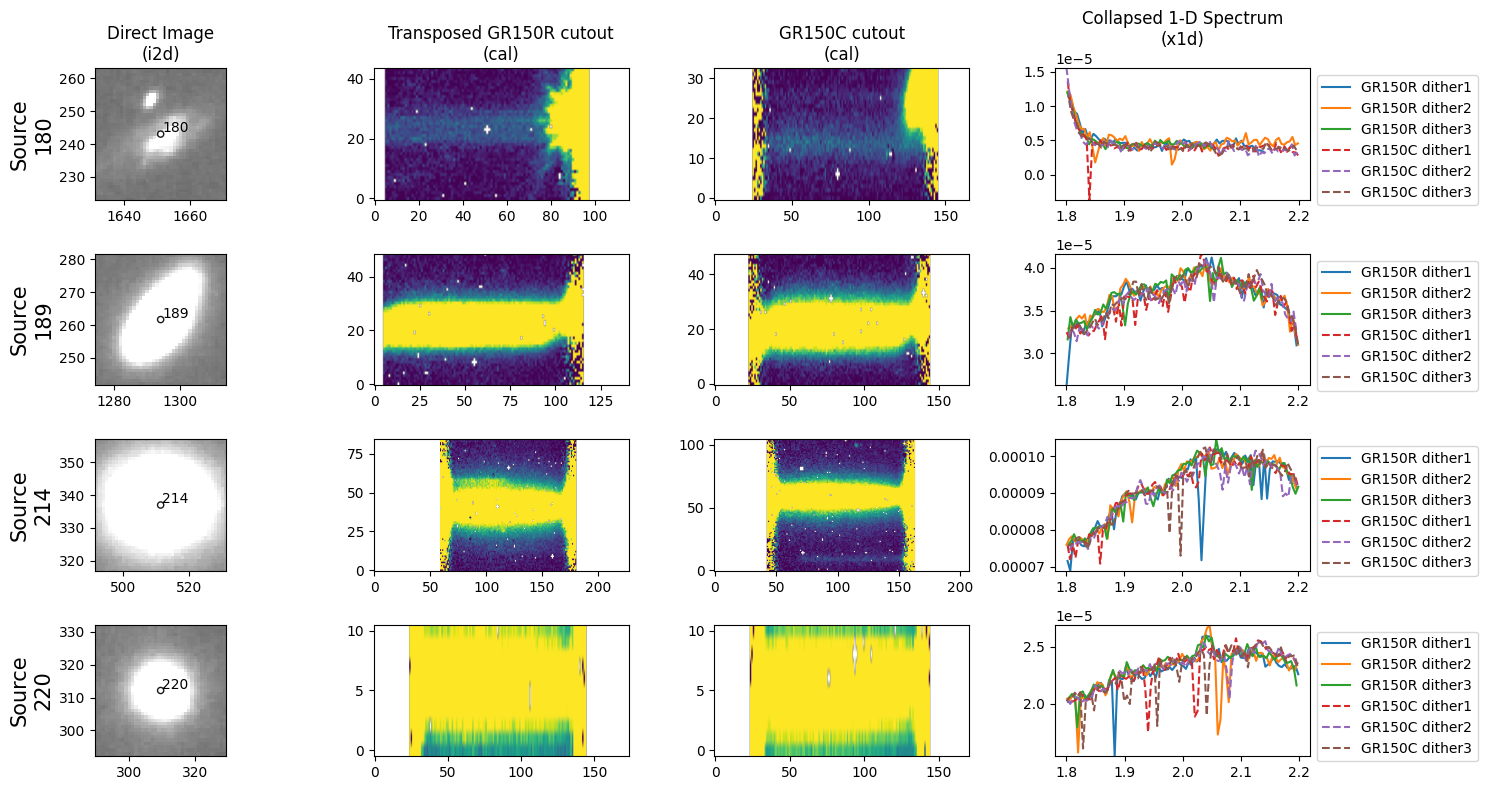

In [104]:
if doviz:
    # grab the spec2 x1d output products
    spec2_x1d_files = sorted(glob.glob(os.path.join(sci_dir, '*nis_x1d.fits*')))
    
    nsources = 4 # 100 sources are extracted by default

    # setting up the figure
    cols = 4
    rows = nsources
    fig = plt.figure(figsize=(15, 4*(rows/2)))

    # because the sources will not be identical across all x1ds, grab a list of sources from the first one
    with fits.open(spec2_x1d_files[0]) as temp_x1d:
        sources = temp_x1d[1].data['SOURCE_ID'][1:nsources+1] # offsetting by 1 b/c first source is fully saturated

    # looping through the different sources to plot; one per row
    for nsource, source_id in enumerate(sources):
        # we are only plotting a single cal file cutout for each grism
        plot_gr150r = True
        plot_gr150c = True

        # setting up the subplots for a single source
        ypos = nsource
        ax_i2d = plt.subplot2grid((rows, cols), (ypos, 0)) 
        ax_cal_r = plt.subplot2grid((rows, cols), (ypos, 1)) 
        ax_cal_c = plt.subplot2grid((rows, cols), (ypos, 2)) 
        ax_x1d = plt.subplot2grid((rows, cols), (ypos, 3))
    
        source_fluxes = [] # save the source flux to set the plot limits

        # plot all of the 1-D spectra from the x1d files
        for nfile, x1dfile in enumerate(spec2_x1d_files):
            with fits.open(x1dfile) as x1d:
                wh_x1d_source = np.where(x1d[1].data['SOURCE_ID'] == source_id)[0]
                if len(wh_x1d_source) == 0:
                    # if the source wasn't extracted, move to the next x1d file
                    continue
                    
                grism = x1d[0].header['FILTER']
                dither = x1d[0].header['PATT_NUM']
                catname = os.path.join(sci_dir, x1d[0].header['SCATFILE'])

                wave = x1d[1].data['WAVELENGTH'][wh_x1d_source]
                flux = x1d[1].data['FLUX'][wh_x1d_source]
                wh_wave = np.where((wave >= 1.8) & (wave <= 2.2)) # cutting off the edges with bad flux calibration
                wave = wave[wh_wave]
                flux = flux[wh_wave]
    
            source_fluxes.extend(flux)
            
            if grism == 'GR150R':
                linestyle = '-'
            else:
                linestyle = '--'
            ax_x1d.plot(wave, flux, label=f"{grism} dither{dither}", ls=linestyle)

            # plot the direct image of the source based on the source number from the source catalog
            if nfile == 0:
                # open the i2d & catalog and find the associated source number            
                i2dname = catname.replace('cat.ecsv', 'i2d.fits')
            
                cat = Table.read(catname)
                cat_line = cat[cat['label'] == source_id]
    
                # plot the image
                with fits.open(i2dname) as i2d:
                    ax_i2d.imshow(i2d[1].data, vmin=0, vmax=0.3, origin='lower', cmap='gist_gray')
    
                # plot up the source catalog
                ax_i2d.set_xlim(cat_line['xcentroid']-20, cat_line['xcentroid']+20)
                ax_i2d.set_ylim(cat_line['ycentroid']-20, cat_line['ycentroid']+20)
                ax_i2d.scatter(cat_line['xcentroid'], cat_line['ycentroid'], s=20, facecolors='None', edgecolors='black', alpha=0.9)
                ax_i2d.annotate(source_id, 
                            (cat_line['xcentroid']+0.5, cat_line['ycentroid']+0.5), 
                            fontsize=10,
                            color='black')
    
            # plot one example cal image from the GR150R grism, transposed to disperse in the same direction as GR150C
            if plot_gr150r and grism == 'GR150R':
                # subplot 2 -- open the cal image and 2D image
                cal_file = x1dfile.replace('x1d.fits', 'cal.fits')
                with fits.open(cal_file) as cal_hdu:
                    wh_cal = find_source_ext(cal_hdu, source_id)
                    cal_data = np.transpose(cal_hdu[wh_cal].data)
                ax_cal_r.imshow(cal_data, vmin=0, vmax=10, origin='lower', aspect='auto')
                plot_gr150r = False
    
            # plot one example cal image from the GR150C grism
            if plot_gr150c and grism == 'GR150C':
                # subplot 2 -- open the cal image and 2D image
                cal_file = x1dfile.replace('x1d.fits', 'cal.fits')
                with fits.open(cal_file) as cal_hdu:
                    wh_cal = find_source_ext(cal_hdu, source_id)
                    cal_data = cal_hdu[wh_cal].data
                ax_cal_c.imshow(cal_data, vmin=0, vmax=10, origin='lower', aspect='auto')
                plot_gr150c = False

        if len(source_fluxes):
            # there may not have been data to extract if everything was saturated
            ax_x1d.set_ylim(np.nanmin(source_fluxes), np.nanmax(source_fluxes))
            ax_x1d.legend(bbox_to_anchor=(1,1))
        
        # Add labels to the subplots
        if nsource == 0:
            ax_cal_r.set_title('Transposed GR150R cutout\n(cal)')
            ax_cal_c.set_title('GR150C cutout\n(cal)')
            ax_i2d.set_title('Direct Image\n(i2d)')
            ax_x1d.set_title('Collapsed 1-D Spectrum\n(x1d)')
        ax_i2d.set_ylabel(f'Source\n{source_id}', fontsize=15)

            
    fig.tight_layout()
    fig.show()

<hr style="border:1px solid gray"> </hr>

## 9. Spec3 Pipeline

NIRISS WFSS data are minimally processed through the [Spec3 stage of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html) to combine calibrated data from multiple dithers within an observation. The spec3 products are unique for a specific grism and blocking filter combination; the different grism data are not combined by default. As of pipeline version 1.19.1, the level 3 source-based `*_cal.fits` files created in this step in the [exp_to_source](https://jwst-pipeline.readthedocs.io/en/latest/jwst/exp_to_source/main.html) step are no longer saved by default, and the `*_x1d.fits` files created in the [extract_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html) and the `*_c1d.fits` files created in the [combine_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/combine_1d/description.html) step are now saved as a single file per grism and filter combination with all of the extracted sources contained within that file.

<a id="spec3_asn"></a>
### Spec3 Association Files

There will be one spec3 association per blocking filter and grism combination, in which all of the extracted 1-D spectra within an observation with that filter and grism combination are coadded into a single spectrum for each source. In the demo case, we are looking at only one blocking filter (F200W) with both grisms (GR150R & GR150C), so we would expect two spec3 association files. There are three dithered exposures per grism for the F200W observation, so each spec3 association file will contain those three `*_cal.fits` files to combine.

In [44]:
if dospec3:
    spec3_asns = glob.glob(os.path.join(sci_dir, "*spec3*_asn.json"))

    # the number of spec3 association files should match the number of grism + filter combinations
    print(len(spec3_asns), 'Spec3 ASN files')
    grism_df = rate_df[(rate_df['FILTER'] == 'GR150R') | (rate_df['FILTER'] == 'GR150C')]
    grism_filter = grism_df['FILTER'] + grism_df['PUPIL']
    print(len(np.unique(grism_filter)), 'unique filter+grism combinations')
    

2 Spec3 ASN files
2 unique filter+grism combinations


In [45]:
if dospec3:
    # look at one of the association files
    asn_data = json.load(open(spec3_asns[1]))
    print(f'asn_type : {asn_data["asn_type"]}')
    print(f'code_version : {asn_data["code_version"]}')

    # in particular, take a closer look at the product filenames with the association file:
    for product in asn_data['products']:
        for key, value in product.items():
            if key == 'members':
                print(f"{key}:")
                for member in value:
                    print(f"    {member['expname']} : {member['exptype']}")
            else:
                print(f"{key}: {value}")

asn_type : spec3
code_version : 1.18.0
name: jw02079-o004_{source_id}_niriss_f200w-gr150c
members:
    jw02079004003_05101_00001_nis_cal.fits : science
    jw02079004003_05101_00002_nis_cal.fits : science
    jw02079004003_05101_00003_nis_cal.fits : science


<a id="spec3_run"></a>
### Run spec3

In Spec3, the `*_cal.fits` files are reorganized based on source number from the Image3 Pipeline's source catalog, extracted into level 3 `*_x1d.fits` files, and then combined into a single 1-D spectrum (`*_c1d.fits` files) for each source. More information about the steps performed during the spec3 stage of the pipeline can be found in the [Spec3 pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html).

In [46]:
if dospec3:
    os.chdir(sci_dir)
    for spec3_asn in spec3_asns:
        # calibrate with spec3 pipeline
        spec2 = Spec3Pipeline.call(spec3_asn, save_results=True)
    os.chdir(cwd)

2025-08-11 11:58:26,083 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2025-08-11 11:58:26,085 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-08-11 11:58:26,086 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2025-08-11 11:58:26,087 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2025-08-11 11:58:26,088 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2025-08-11 11:58:26,089 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2025-08-11 11:58:26,091 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2025-08-11 11:58:26,092 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-08-11 11:58:26,094 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-08-11 11:58:26,095 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep in

<a id="spec3_examine"></a>
### Examining the Outputs of Spec3

The outputs of spec3 are `*_x1d.fits` and `*_c1d.fits` files. Here we do a quick look into some important parts of these files.

Each extension of the spec3 `*_x1d.fits` files contains the extracted, 1-D spectra for an individual dither for a single grism, filter, and extracted order combination. The specific filenames and extracted order can be verified with the `FILENAME` and `SPORDER` keywords in the header of each extension respectively. Within the extension, each of the extracted sources across all dithers are listed, with the values being empty if the particular dither did not contain data for that source. Also contained within each extension is information related to the extraction of a particular source, including the extents and starting size of the extraction box in the full reference frame. More information about the columns contained withing the `*_x1d.fits` files can be found in the [x1d filetype documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#extracted-1-d-spectroscopic-data-x1d-and-x1dints).

In [71]:
# the level 3 products have a different naming scheme
spec3_x1ds = sorted(glob.glob(os.path.join(sci_dir, "jw?????-o???_*x1d.fits")))
sample_x1d = fits.open(spec3_x1ds[0])

print("***Format of the level 3 x1d file:")
sample_x1d.info()

print("\n***Files contained in the level 3 x1d file:")
for ext in range(len(sample_x1d))[1:-1]:
    print(f"Extension {ext}: {sample_x1d[ext].header['FILENAME']}, order {sample_x1d[ext].header['SPORDER']}")

print("\n***Columns contained in each extension of the level 3 x1d file:")
sample_x1d[1].data.columns

***Format of the level 3 x1d file:
Filename: /user/rplesha/aux_jwst_pipeline_repos/jwst-pipeline-notebooks/notebooks/NIRISS/WFSS/nis_wfss_demo_data/2079/obs004/jw02079-o004_{source_id}_niriss_f200w-gr150c_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     363   ()      
  1  EXTRACT1D     1 BinTableHDU    123   101R x 29C   [J, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271J, 271D, 271D, 271D, 271D, 271D, 271D, J, 20A, D, D, D, D, J, J, J, J]   
  2  EXTRACT1D     2 BinTableHDU    122   101R x 29C   [J, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271J, 271D, 271D, 271D, 271D, 271D, 271D, J, 20A, D, D, D, D, J, J, J, J]   
  3  EXTRACT1D     3 BinTableHDU    122   101R x 29C   [J, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271D, 271J, 271D, 271D, 271D, 271D, 271D, 271D, J, 20A, D, D, D, D, J, J, J, J]   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [15491B]   

**

ColDefs(
    name = 'SOURCE_ID'; format = 'J'
    name = 'WAVELENGTH'; format = '271D'; unit = 'um'; dim = '(271)'
    name = 'FLUX'; format = '271D'; unit = 'Jy'; dim = '(271)'
    name = 'FLUX_ERROR'; format = '271D'; unit = 'Jy'; dim = '(271)'
    name = 'FLUX_VAR_POISSON'; format = '271D'; unit = 'Jy^2'; dim = '(271)'
    name = 'FLUX_VAR_RNOISE'; format = '271D'; unit = 'Jy^2'; dim = '(271)'
    name = 'FLUX_VAR_FLAT'; format = '271D'; unit = 'Jy^2'; dim = '(271)'
    name = 'SURF_BRIGHT'; format = '271D'; unit = 'MJy/sr'; dim = '(271)'
    name = 'SB_ERROR'; format = '271D'; unit = 'MJy/sr'; dim = '(271)'
    name = 'SB_VAR_POISSON'; format = '271D'; unit = 'MJy^2 / sr^2'; dim = '(271)'
    name = 'SB_VAR_RNOISE'; format = '271D'; unit = 'MJy^2 / sr^2'; dim = '(271)'
    name = 'SB_VAR_FLAT'; format = '271D'; unit = 'MJy^2 / sr^2'; dim = '(271)'
    name = 'DQ'; format = '271J'; bzero = 2147483648; dim = '(271)'
    name = 'BACKGROUND'; format = '271D'; unit = 'MJy/sr'; dim = '(2

The `*_c1d.fits` files contain combined extensions of the same order in the spec3 `*_x1d.fits` files into a single file. The source numbers in the `*_c1d.fits` match those in the level 3 `*_x1d.fits` files. More information about the columns contained withing the `*_c1d.fits` files can be found in the [c1d filetype documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#combined-1-d-spectroscopic-data-c1d).

In [76]:
# the level 3 products have a different naming scheme
spec3_c1ds = sorted(glob.glob(os.path.join(sci_dir, "jw?????-o???_*c1d.fits")))
sample_c1d = fits.open(spec3_c1ds[0])

print("***Format of the c1d file:")
sample_c1d.info()

print("\n***Files contained in the c1d file:")
for ext in range(len(sample_c1d))[1:-1]:
    print(f"Extension {ext}: order {sample_c1d[ext].header['SPORDER']}")
    
print("\n***Columns contained in each extension of the c1d file:")
sample_c1d[1].data.columns

***Format of the c1d file:
Filename: /user/rplesha/aux_jwst_pipeline_repos/jwst-pipeline-notebooks/notebooks/NIRISS/WFSS/nis_wfss_demo_data/2079/obs004/jw02079-o004_{source_id}_niriss_f200w-gr150c_c1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     368   ()      
  1  COMBINE1D     1 BinTableHDU     55   100R x 13C   [J, 124D, 124D, 124D, 124D, 124D, 124J, 124D, 124D, J, 20A, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [8553B]   

***Files contained in the c1d file:
Extension 1: order 1

***Columns contained in each extension of the c1d file:


ColDefs(
    name = 'SOURCE_ID'; format = 'J'
    name = 'WAVELENGTH'; format = '124D'; unit = 'um'; dim = '(124)'
    name = 'FLUX'; format = '124D'; unit = 'Jy'; dim = '(124)'
    name = 'ERROR'; format = '124D'; unit = 'Jy'; dim = '(124)'
    name = 'SURF_BRIGHT'; format = '124D'; unit = 'MJy/sr'; dim = '(124)'
    name = 'SB_ERROR'; format = '124D'; unit = 'MJy/sr'; dim = '(124)'
    name = 'DQ'; format = '124J'; bzero = 2147483648; dim = '(124)'
    name = 'WEIGHT'; format = '124D'; dim = '(124)'
    name = 'N_INPUT'; format = '124D'; dim = '(124)'
    name = 'N_ALONGDISP'; format = 'J'; bzero = 2147483648
    name = 'SOURCE_TYPE'; format = '20A'
    name = 'SOURCE_RA'; format = 'D'; unit = 'degrees'
    name = 'SOURCE_DEC'; format = 'D'; unit = 'degrees'
)

Digging a little bit further into the different source IDs and how those are handled, you can see that in each extension the sources are identical.  

In [52]:
for ext in np.arange(len(sample_x1d))[1:-1]:
    print(f"Extension {ext}: {sample_x1d[ext].header['FILENAME']}, Order {sample_x1d[ext].header['SPORDER']}")
    print("  Sources:\n", sample_x1d[ext].data['SOURCE_ID'])

Extension 1: jw02079004003_05101_00001_nis_cal.fits, Order 1
  Sources:
 [ 124  180  189  214  220  263  274  276  289  298  345  347  385  387
  389  417  422  439  493  505  516  522  527  533  536  539  540  543
  553  557  566  567  605  606  610  630  641  649  654  682  693  694
  712  719  721  722  732  733  736  749  759  766  772  796  800  821
  872  873  881  898  914  922  925  927  933  934  966  973  980  981
  982 1008 1029 1049 1084 1120 1128 1140 1142 1162 1188 1194 1219 1253
 1257 1266 1282 1296 1342 1364 1371 1387 1388 1407 1412 1417 1423 1442
 1457 1476 1479]
Extension 2: jw02079004003_05101_00002_nis_cal.fits, Order 1
  Sources:
 [ 124  180  189  214  220  263  274  276  289  298  345  347  385  387
  389  417  422  439  493  505  516  522  527  533  536  539  540  543
  553  557  566  567  605  606  610  630  641  649  654  682  693  694
  712  719  721  722  732  733  736  749  759  766  772  796  800  821
  872  873  881  898  914  922  925  927  933  934  966 

If a source wasn't extracted for a file, the values will be filled in with a value of "0" or "nan". In this example, we look at where the column `N_ALONGDISP` is zero to find which sources aren't extracted in certain files. `N_ALONGDISP` represents the number of pixels in the trace along the dispersion direction, so if it is zero, no pixels were used.

In [53]:
# looking at extension 1 (first file) as an example of what a source looks like if it's not extracted
ext = 1
wh_no_source = np.where(sample_x1d[ext].data['N_ALONGDISP'] == 0)[0]
if len(wh_no_source) > 0:
    print(f"{sample_x1d[ext].header['FILENAME']} does not extract the following sources:")
    print(f"  {sample_x1d[ext].data['SOURCE_ID'][wh_no_source]}")
    print("Unique values in the different columns:")
    for colname in sample_x1d[ext].data.names:
        print(f"  {colname} : {np.unique(sample_x1d[ext].data[colname][wh_no_source[0]])}")

jw02079004003_05101_00001_nis_cal.fits does not extract the following sources:
  [124]
Unique values in the different columns:
  SOURCE_ID : [124]
  WAVELENGTH : [nan]
  FLUX : [nan]
  FLUX_ERROR : [nan]
  FLUX_VAR_POISSON : [nan]
  FLUX_VAR_RNOISE : [nan]
  FLUX_VAR_FLAT : [nan]
  SURF_BRIGHT : [nan]
  SB_ERROR : [nan]
  SB_VAR_POISSON : [nan]
  SB_VAR_RNOISE : [nan]
  SB_VAR_FLAT : [nan]
  DQ : [1]
  BACKGROUND : [nan]
  BKGD_ERROR : [nan]
  BKGD_VAR_POISSON : [nan]
  BKGD_VAR_RNOISE : [nan]
  BKGD_VAR_FLAT : [nan]
  NPIXELS : [nan]
  N_ALONGDISP : [0]
  SOURCE_TYPE : ['']
  SOURCE_XPOS : [nan]
  SOURCE_YPOS : [nan]
  SOURCE_RA : [nan]
  SOURCE_DEC : [nan]
  EXTRACT2D_XSTART : [0]
  EXTRACT2D_YSTART : [0]
  EXTRACT2D_XSTOP : [0]
  EXTRACT2D_YSTOP : [0]


#### Visualizing spec3

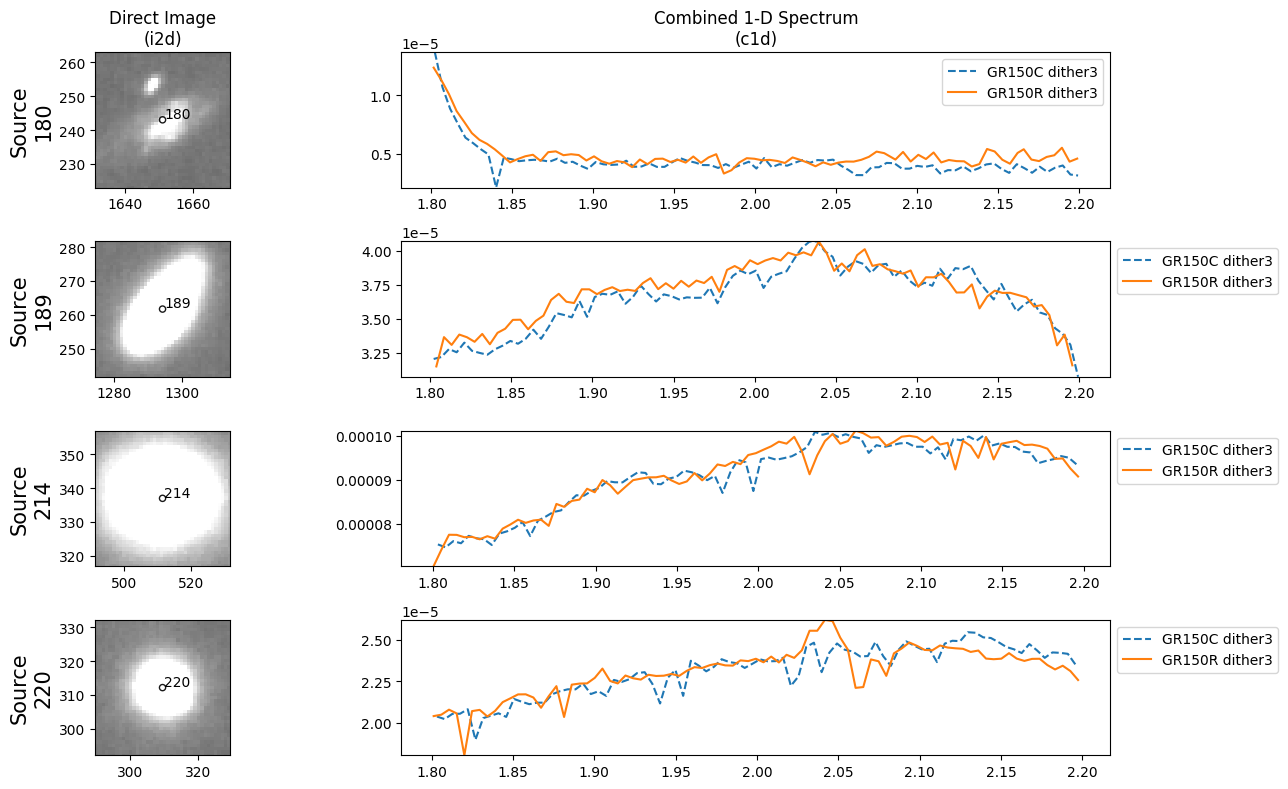

In [105]:
if doviz:
    
    nsources = 4 # 100 sources are extracted by default

    # setting up the figure
    cols = 2
    rows = nsources
    fig = plt.figure(figsize=(15, 4*(rows/2)))

    # because the sources will not be identical across all x1ds, grab a list of sources from the first one
    with fits.open(spec3_c1ds[0]) as temp_c1d:
        sources = temp_c1d[1].data['SOURCE_ID'][1:nsources+1] # offsetting by 1 b/c first source is fully saturated

    # looping through the different sources to plot; one per row
    for nsource, source_id in enumerate(sources):

        # setting up the subplots for a single source
        ypos = nsource
        ax_i2d = plt.subplot2grid((rows, cols), (ypos, 0)) 
        ax_c1d = plt.subplot2grid((rows, cols), (ypos, 1))
    
        source_fluxes = [] # save the source flux to set the plot limits

        # plot all of the 1-D spectra from the x1d files
        for nfile, c1dfile in enumerate(spec3_c1ds):
            with fits.open(c1dfile) as c1d:
                wh_c1d_source = np.where(c1d[1].data['SOURCE_ID'] == source_id)[0]
                    
                grism = c1d[0].header['FILTER']
                catname = os.path.join(sci_dir, c1d[0].header['SCATFILE'])

                wave = c1d[1].data['WAVELENGTH'][wh_c1d_source]
                flux = c1d[1].data['FLUX'][wh_c1d_source]
                wh_wave = np.where((wave >= 1.8) & (wave <= 2.2)) # cutting off the edges with bad flux calibration
                wave = wave[wh_wave]
                flux = flux[wh_wave]
    
            source_fluxes.extend(flux)
            
            if grism == 'GR150R':
                linestyle = '-'
            else:
                linestyle = '--'
            ax_c1d.plot(wave, flux, label=f"{grism} dither{dither}", ls=linestyle)
            
            # plot the direct image of the source based on the source number from the source catalog
            if nfile == 0:
                # open the i2d & catalog and find the associated source number            
                i2dname = catname.replace('cat.ecsv', 'i2d.fits')
            
                cat = Table.read(catname)
                cat_line = cat[cat['label'] == source_id]
    
                # plot the image
                with fits.open(i2dname) as i2d:
                    ax_i2d.imshow(i2d[1].data, vmin=0, vmax=0.3, origin='lower', cmap='gist_gray')
    
                # plot up the source catalog
                ax_i2d.set_xlim(cat_line['xcentroid']-20, cat_line['xcentroid']+20)
                ax_i2d.set_ylim(cat_line['ycentroid']-20, cat_line['ycentroid']+20)
                ax_i2d.scatter(cat_line['xcentroid'], cat_line['ycentroid'], s=20, facecolors='None', edgecolors='black', alpha=0.9)
                ax_i2d.annotate(source_id, 
                            (cat_line['xcentroid']+0.5, cat_line['ycentroid']+0.5), 
                            fontsize=10,
                            color='black')

        if len(source_fluxes):
            # there may not have been data to extract if everything was saturated
            ax_c1d.set_ylim(np.nanmin(source_fluxes), np.nanmax(source_fluxes))
            ax_c1d.legend(bbox_to_anchor=(1,1))
        
        # Add labels to the subplots
        if nsource == 0:
            ax_i2d.set_title('Direct Image\n(i2d)')
            ax_c1d.set_title('Combined 1-D Spectrum\n(c1d)')
        ax_i2d.set_ylabel(f'Source\n{source_id}', fontsize=15)

            
    fig.tight_layout()
    fig.show()

<hr style="border:1px solid gray"> </hr>